### daily region data

### Cài đặt thư viện Meteostat để thu thập dữ liệu thời tiết
Meteostat là thư viện Python để truy cập dữ liệu thời tiết lịch sử từ nhiều trạm quan trắc trên thế giới.

In [ ]:
# Cài đặt thư viện Meteostat
!pip install meteostat

In [ ]:
# Class để thu thập dữ liệu thời tiết
from meteostat import Daily, Point
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import warnings
warnings.filterwarnings('ignore')

class WeatherDataCollector:
    def __init__(self):
        """
        Khởi tạo WeatherDataCollector
        """
        # Định nghĩa các điểm quan trắc thời tiết cho các vùng điện chính của Mỹ
        self.region_weather_points = {
            'CAISO': Point(34.0522, -118.2437),  # Los Angeles, CA
            'PJM': Point(39.2904, -76.6122),     # Baltimore, MD
            'ERCOT': Point(30.2672, -97.7431),   # Austin, TX
            'MISO': Point(41.8781, -87.6298),    # Chicago, IL
            'SPP': Point(39.7391, -94.6857),     # Kansas City, MO
            'ISONE': Point(42.3601, -71.0589),   # Boston, MA
            'NYISO': Point(40.7128, -74.0060),   # New York, NY
            'SWPP': Point(35.4676, -97.5164),    # Oklahoma City, OK
            'BPAT': Point(45.5152, -122.6784),   # Portland, OR
            'CPLE': Point(35.2271, -80.8431),    # Charlotte, NC
            'DUK': Point(35.9940, -78.8986),     # Raleigh, NC
            'FPC': Point(27.9506, -82.4572),     # Tampa, FL
            'FPL': Point(25.7617, -80.1918),     # Miami, FL
            'PACE': Point(30.4518, -84.2807),    # Tallahassee, FL
            'PSCO': Point(39.7392, -104.9903),   # Denver, CO
            'SC': Point(34.0000, -81.0348),      # Columbia, SC
            'SCEG': Point(34.0000, -81.0348),    # Columbia, SC
            'SEC': Point(33.4484, -86.8017),     # Birmingham, AL
            'SOCO': Point(33.7490, -84.3880),    # Atlanta, GA
            'SRP': Point(33.4484, -112.0740),    # Phoenix, AZ
            'TAL': Point(32.8207, -83.6324),     # Macon, GA
            'TEC': Point(25.7617, -80.1918),    # Miami, FL
            'TVA': Point(35.2131, -101.8313),    # Amarillo, TX
            'WACM': Point(47.0379, -122.9015),   # Olympia, WA
            'WALC': Point(33.4484, -112.0740),   # Phoenix, AZ
            'WAUW': Point(47.6062, -122.3321),   # Seattle, WA
        }

        # Các tham số thời tiết quan trọng ảnh hưởng đến nhu cầu điện
        self.weather_features = [
            'tavg',    # Nhiệt độ trung bình (°C)
            'tmin',    # Nhiệt độ tối thiểu (°C)
            'tmax',    # Nhiệt độ tối đa (°C)
            'prcp',    # Lượng mưa (mm)
            'wspd',    # Tốc độ gió (km/h)
            'pres',    # Áp suất khí quyển (hPa)
            'tsun',    # Thời gian nắng (phút)
        ]

    def get_weather_data(self, region: str, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Thu thập dữ liệu thời tiết cho một vùng cụ thể

        Args:
            region: Tên vùng (ví dụ: 'CAISO', 'PJM', ...)
            start_date: Ngày bắt đầu (YYYY-MM-DD)
            end_date: Ngày kết thúc (YYYY-MM-DD)

        Returns:
            DataFrame chứa dữ liệu thời tiết
        """
        if region not in self.region_weather_points:
            print(f"⚠️ Vùng '{region}' không có trong danh sách. Sử dụng điểm mặc định (New York).")
            weather_point = self.region_weather_points['NYISO']
        else:
            weather_point = self.region_weather_points[region]

        print(f"🌤️ Thu thập dữ liệu thời tiết cho vùng: {region}")
        # Removed the print statement that caused the AttributeError
        # print(f"📍 Tọa độ: {weather_point.lat}, {weather_point.lon}")
        print(f"📅 Thời gian: {start_date} đến {end_date}")

        try:
            # Chuyển đổi định dạng ngày
            start = datetime.strptime(start_date, '%Y-%m-%d')
            end = datetime.strptime(end_date, '%Y-%m-%d')

            # Thu thập dữ liệu từ Meteostat
            data = Daily(weather_point, start, end)
            weather_df = data.fetch()

            if weather_df.empty:
                print(f"❌ Không có dữ liệu thời tiết cho vùng {region}")
                return pd.DataFrame()

            # Reset index để có cột date
            weather_df = weather_df.reset_index()
            weather_df['region'] = region
            weather_df['date'] = weather_df['time']

            # Chọn các cột cần thiết
            available_cols = ['time', 'region'] + [col for col in self.weather_features if col in weather_df.columns]
            weather_df = weather_df[available_cols]

            print(f"✅ Thu thập thành công {len(weather_df)} ngày dữ liệu thời tiết")
            print(f"📊 Các chỉ số thời tiết có sẵn: {[col for col in self.weather_features if col in weather_df.columns]}")

            return weather_df

        except Exception as e:
            print(f"❌ Lỗi khi thu thập dữ liệu thời tiết: {e}")
            return pd.DataFrame()

    def get_all_regions_weather(self, regions: list, start_date: str, end_date: str) -> pd.DataFrame:
        """
        Thu thập dữ liệu thời tiết cho tất cả các vùng

        Args:
            regions: Danh sách các vùng
            start_date: Ngày bắt đầu
            end_date: Ngày kết thúc

        Returns:
            DataFrame chứa dữ liệu thời tiết cho tất cả các vùng
        """
        all_weather_data = []

        print(f"🌍 Thu thập dữ liệu thời tiết cho {len(regions)} vùng...")

        for i, region in enumerate(regions, 1):
            print(f"\n📍 Vùng {i}/{len(regions)}: {region}")
            weather_data = self.get_weather_data(region, start_date, end_date)

            if not weather_data.empty:
                all_weather_data.append(weather_data)

            # Nghỉ ngắn để không quá tải API
            import time
            time.sleep(0.5)

        if all_weather_data:
            combined_weather = pd.concat(all_weather_data, ignore_index=True)
            print(f"\n🎉 Hoàn thành thu thập dữ liệu thời tiết!")
            print(f"📊 Tổng số bản ghi: {len(combined_weather)}")
            print(f"🌎 Số vùng: {combined_weather['region'].nunique()}")
            return combined_weather
        else:
            print("❌ Không thu thập được dữ liệu thời tiết nào!")
            return pd.DataFrame()

    def add_weather_features(self, weather_df: pd.DataFrame) -> pd.DataFrame:
        """
        Thêm các đặc trưng thời tiết phát sinh

        Args:
            weather_df: DataFrame dữ liệu thời tiết gốc

        Returns:
            DataFrame với các đặc trưng bổ sung
        """
        if weather_df.empty:
            return weather_df

        df = weather_df.copy()

        print("🔧 Tạo các đặc trưng thời tiết bổ sung...")

        # Chỉ số nhiệt độ
        if 'tmax' in df.columns and 'tmin' in df.columns:
            df['temp_range'] = df['tmax'] - df['tmin']  # Biên độ nhiệt độ

        if 'tavg' in df.columns:
            # Chỉ số Cooling Degree Days (CDD) - cho điều hòa
            df['cdd'] = np.maximum(df['tavg'] - 18, 0)  # 18°C là ngưỡng
            # Chỉ số Heating Degree Days (HDD) - cho sưởi ấm
            df['hdd'] = np.maximum(18 - df['tavg'], 0)

            # Nhiệt độ cực đoan (Handle potential NaNs by filling with 0 before converting to int)
            df['temp_extreme_cold'] = (df['tavg'].fillna(0) < 0).astype(int)
            df['temp_extreme_hot'] = (df['tavg'].fillna(0) > 35).astype(int)

        # Chỉ số gió (Handle potential NaNs)
        if 'wspd' in df.columns:
            df['wind_high'] = (df['wspd'].fillna(0) > 20).astype(int)  # Gió mạnh (>20 km/h)

        # Chỉ số mưa (Handle potential NaNs)
        if 'prcp' in df.columns:
            df['rain_day'] = (df['prcp'].fillna(0) > 0).astype(int)
            df['heavy_rain'] = (df['prcp'].fillna(0) > 10).astype(int)  # Mưa lớn (>10mm)

        # Chỉ số áp suất (Handle potential NaNs)
        if 'pres' in df.columns:
            df['pressure_low'] = (df['pres'].fillna(1013) < 1000).astype(int)  # Áp suất thấp (fill with average pressure)
            df['pressure_high'] = (df['pres'].fillna(1013) > 1020).astype(int) # Áp suất cao (fill with average pressure)


        # Lag features cho thời tiết (ảnh hưởng của thời tiết ngày trước)
        if 'region' in df.columns:
            for col in ['tavg', 'tmax', 'tmin', 'prcp', 'wspd']:
                if col in df.columns:
                    # Fill NaNs after shifting to avoid errors in calculations
                    df[f'{col}_lag1'] = df.groupby('region')[col].shift(1)
                    df[f'{col}_lag3'] = df.groupby('region')[col].shift(3)

                    # Rolling averages
                    df[f'{col}_ma7'] = df.groupby('region')[col].transform(
                        lambda x: x.rolling(window=7, min_periods=1).mean()
                    )
        # Fill NaNs created by shift/rolling operations with 0 or a sensible value if needed later
        # For now, leaving NaNs is acceptable for these features as they will be handled by ML models

        print(f"✅ Đã tạo {len(df.columns) - len(weather_df.columns)} đặc trưng thời tiết bổ sung")

        return df

# Tạo instance của collector
weather_collector = WeatherDataCollector()
print("✅ WeatherDataCollector đã được khởi tạo!")

✅ WeatherDataCollector đã được khởi tạo!


In [ ]:
# step1_daily_region_data_loader.py
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

class EIADailyRegionDataLoader:
    def __init__(self, api_key: str):
        self.api_key = api_key
        self.base_url = "https://api.eia.gov/v2"

    def load_daily_region_data(self,
                              start_date: str = "2020-06-01",
                              end_date: str = "2022-06-01",
                              save_to_csv: bool = True,
                              max_records: int = None) -> pd.DataFrame:
        """
        Load daily electricity regional data using your specific URL

        Args:
            start_date: Start date in format "YYYY-MM-DD"
            end_date: End date in format "YYYY-MM-DD"
            save_to_csv: Whether to save data to CSV file
            max_records: Maximum number of records to collect (None = all)
        """

        print(f"🔌📊 Loading DAILY REGIONAL electricity data")
        print(f"📅 Period: {start_date} to {end_date}")
        print(f"👤 Current User: tructd123")
        print(f"🕐 Current Time: 2025-06-14 16:53:17 UTC")
        print("-" * 70)

        # Base URL from your example
        base_url = "https://api.eia.gov/v2/electricity/rto/daily-region-data/data/"

        # Parameters based on your URL
        params = {
            'api_key': self.api_key,
            'frequency': 'daily',
            'data[0]': 'value',
            'start': start_date,
            'end': end_date,
            'sort[0][column]': 'period',
            'sort[0][direction]': 'asc',
            'offset': 0,
            'length': 5000
        }

        all_data = []
        offset = 0
        batch_count = 0
        start_time = time.time()

        print(f"🚀 Starting data collection...")

        while True:
            batch_count += 1
            print(f"📥 Fetching batch {batch_count} (offset: {offset:,})...")

            # Update offset parameter
            params['offset'] = offset

            try:
                response = requests.get(base_url, params=params, timeout=60)
                response.raise_for_status()

                print(f"✅ Response status: {response.status_code}")

                data = response.json()

                # Debug: Show response structure for first batch
                if batch_count == 1:
                    print("\n🔍 API Response structure:")
                    if 'response' in data:
                        print(f"  - response keys: {list(data['response'].keys())}")
                        if 'data' in data['response']:
                            print(f"  - data length: {len(data['response']['data'])}")
                            if data['response']['data']:
                                print(f"  - first record keys: {list(data['response']['data'][0].keys())}")
                                print(f"  - sample record:")
                                print(json.dumps(data['response']['data'][0], indent=4))
                    print()

                if 'response' in data and 'data' in data['response']:
                    batch_data = data['response']['data']

                    if not batch_data:  # No more data
                        print("📭 No more data available.")
                        break

                    all_data.extend(batch_data)
                    elapsed_time = time.time() - start_time

                    print(f"✅ Loaded {len(batch_data):,} records | Total: {len(all_data):,} | "
                          f"Time: {elapsed_time:.1f}s | Rate: {len(all_data)/elapsed_time:.1f} rec/s")

                    # Check max records limit
                    if max_records and len(all_data) >= max_records:
                        print(f"🛑 Reached maximum records limit ({max_records:,}). Stopping.")
                        all_data = all_data[:max_records]
                        break

                    # Check if we got less than the limit (last page)
                    if len(batch_data) < 5000:
                        print("📄 Reached last page of data.")
                        break

                    offset += 5000

                    # Rate limiting - be respectful to the API
                    time.sleep(0.3)

                    # Safety limit
                    if batch_count > 1000:  # Reasonable limit for daily data
                        print("⚠️ Reached batch limit (1000). Stopping for safety.")
                        break

                else:
                    print("⚠️ No data in API response")
                    if 'error' in data:
                        print(f"❌ API Error: {data['error']}")
                    elif 'errors' in data:
                        print(f"❌ API Errors: {data['errors']}")
                    break

            except requests.exceptions.RequestException as e:
                print(f"❌ Request error: {e}")
                print("🔄 Retrying in 5 seconds...")
                time.sleep(5)
                continue
            except json.JSONDecodeError as e:
                print(f"❌ JSON decode error: {e}")
                print(f"Response text preview: {response.text[:500]}...")
                break
            except Exception as e:
                print(f"❌ Unexpected error: {e}")
                break

        total_time = time.time() - start_time

        if not all_data:
            print("❌ No data collected!")
            return pd.DataFrame()

        print(f"\n🎉 Data collection completed!")
        print(f"📊 Total records collected: {len(all_data):,}")
        print(f"⏱️ Total time: {total_time:.1f} seconds")
        print(f"📈 Average rate: {len(all_data)/total_time:.1f} records/second")

        # Convert to DataFrame
        df = pd.DataFrame(all_data)

        print(f"📋 Data columns: {df.columns.tolist()}")
        print(f"📏 Data shape: {df.shape}")

        # --- ADDED: Convert 'value' to numeric and handle nulls immediately ---
        if 'value' in df.columns:
            original_nulls = df['value'].isnull().sum()
            df['value'] = pd.to_numeric(df['value'], errors='coerce')
            new_nulls = df['value'].isnull().sum()
            print(f"✅ Converted value to numeric. NaN values: {new_nulls:,} (was {original_nulls:,})")

        # Remove null values in critical columns
        initial_rows = len(df)
        df = df.dropna(subset=['value'])
        removed_rows = initial_rows - len(df)
        print(f"✅ Removed {removed_rows:,} rows with null values ({removed_rows/initial_rows*100:.2f}%)")
        # --- END ADDED ---


        # Show sample data
        print(f"\n📋 Sample records:")
        print(df.head())

        # Show unique values for key columns
        if 'respondent' in df.columns:
            respondents = sorted(df['respondent'].unique())
            print(f"\n🌎 Available regions/respondents ({len(respondents)}):")
            for i, resp in enumerate(respondents, 1):
                count = len(df[df['respondent'] == resp])
                # Now 'value' is numeric, so .mean() should work
                avg_value = df[df['respondent'] == resp]['value'].mean() if 'value' in df.columns and not df[df['respondent'] == resp].empty else 0
                print(f"  {i:2d}. {resp} ({count:,} records, avg: {avg_value:.2f})")

        if 'type' in df.columns:
            types = sorted(df['type'].unique())
            print(f"\n📈 Available data types: {types}")

        if 'type-name' in df.columns:
            type_names = sorted(df['type-name'].unique())
            print(f"\n📈 Available type names: {type_names}")

        # Data cleaning and preprocessing (remaining steps)
        # We pass the already cleaned/numeric DataFrame here
        df = self.preprocess_daily_region_data(df)

        if save_to_csv:
            # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            filename = f"daily_region_data_{start_date}_to_{end_date}.csv"

            print(f"\n💾 Saving data to {filename}...")
            df.to_csv(filename, index=False)

            # Also save a summary file
            summary_filename = f"daily_region_summary.csv"
            if 'respondent' in df.columns:
                # Ensure we use the preprocessed (cleaned) dataframe for summary
                summary = df.groupby('respondent').agg({
                    'value': ['count', 'mean', 'std', 'min', 'max', 'sum']
                }).round(2)
                summary.to_csv(summary_filename)
                print(f"📊 Summary saved to: {summary_filename}")

            print(f"✅ Full data saved to: {filename}")

        return df

    def preprocess_daily_region_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Clean and preprocess the daily regional electricity data"""

        print(f"\n🔧 Preprocessing daily regional data...")

        # Show original columns and data types
        # Note: 'value' column should now be numeric due to processing in load_daily_region_data
        print(f"📋 Columns: {df.columns.tolist()}")
        print(f"📊 Shape: {df.shape}")

        # Convert period to datetime
        if 'period' in df.columns:
            print("📅 Converting period to datetime...")
            # Check if already datetime (from load_daily_region_data)
            if not pd.api.types.is_datetime64_any_dtype(df['period']):
                 df['period'] = pd.to_datetime(df['period'])
            print(f"✅ Period range: {df['period'].min()} to {df['period'].max()}")

        # Note: Value conversion and NaN handling are now done in load_daily_region_data

        # Sort data
        sort_columns = ['period']
        if 'respondent' in df.columns:
            sort_columns = ['respondent', 'period']
        if 'type' in df.columns:
            sort_columns = ['respondent', 'type', 'period'] if 'respondent' in df.columns else ['type', 'period']

        print(f"🔄 Sorting data by: {sort_columns}")
        df = df.sort_values(sort_columns)
        df = df.reset_index(drop=True)
        print("✅ Data sorted and reindexed")

        # Add comprehensive time-based features
        print("📅 Adding time-based features...")
        df['year'] = df['period'].dt.year
        df['month'] = df['period'].dt.month
        df['day'] = df['period'].dt.day
        df['day_of_week'] = df['period'].dt.dayofweek
        df['day_of_year'] = df['period'].dt.dayofyear
        df['week_of_year'] = df['period'].dt.isocalendar().week # .isocalendar().week returns a Series, needs .week accessor
        df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
        df['quarter'] = df['period'].dt.quarter

        # Month day for seasonal patterns
        df['month_day'] = df['period'].dt.strftime('%m-%d')

        # Season mapping
        def get_season(month):
            if month in [12, 1, 2]:
                return 'Winter'
            elif month in [3, 4, 5]:
                return 'Spring'
            elif month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Fall'

        df['season'] = df['month'].apply(get_season)

        # Holiday indicators (basic US holidays)
        df['date'] = df['period'].dt.date
        # Check if year range is valid for holidays
        if not df.empty:
             min_year = df['year'].min()
             max_year = df['year'].max()
             holidays = self.get_us_holidays(min_year, max_year)
             df['is_holiday'] = df['date'].isin(holidays).astype(int)
        else:
             df['is_holiday'] = 0 # Add column even if empty
             holidays = set() # Define holidays even if empty

        # Business day indicator
        df['is_business_day'] = ((df['day_of_week'] < 5) & (df['is_holiday'] == 0)).astype(int)

        print("✅ Added comprehensive time-based features")

        # Add lag features for demand forecasting
        print("🔄 Computing lag and rolling features...")

        # Only attempt lag/rolling features if there is data and relevant columns exist
        if not df.empty and 'value' in df.columns:
            if 'respondent' in df.columns and 'type' in df.columns:
                print("  - Computing features by region and type...")
                groupby_cols = ['respondent', 'type']

                # Lag features
                df['demand_lag_1d'] = df.groupby(groupby_cols)['value'].shift(1)
                df['demand_lag_7d'] = df.groupby(groupby_cols)['value'].shift(7)
                df['demand_lag_30d'] = df.groupby(groupby_cols)['value'].shift(30)
                df['demand_lag_365d'] = df.groupby(groupby_cols)['value'].shift(365)  # Year-over-year

                # Rolling averages
                print("    - Computing rolling averages...")
                df['demand_ma_7d'] = df.groupby(groupby_cols)['value'].transform(
                    lambda x: x.rolling(window=7, min_periods=1).mean()
                )
                df['demand_ma_30d'] = df.groupby(groupby_cols)['value'].transform(
                    lambda x: x.rolling(window=30, min_periods=1).mean()
                )
                df['demand_ma_90d'] = df.groupby(groupby_cols)['value'].transform(
                    lambda x: x.rolling(window=90, min_periods=1).mean()
                )

                # Trend features
                df['demand_trend_7d'] = df['value'] - df['demand_lag_7d']
                df['demand_trend_30d'] = df['value'] - df['demand_lag_30d']
                df['demand_growth_rate_7d'] = ((df['value'] - df['demand_lag_7d']) /
                                              (df['demand_lag_7d'] + 1e-6) * 100).fillna(0)
                df['demand_growth_rate_30d'] = ((df['value'] - df['demand_lag_30d']) /
                                               (df['demand_lag_30d'] + 1e-6) * 100).fillna(0)

                # Year-over-year comparison
                df['demand_yoy_change'] = df['value'] - df['demand_lag_365d']
                df['demand_yoy_growth'] = ((df['value'] - df['demand_lag_365d']) /
                                          (df['demand_lag_365d'] + 1e-6) * 100).fillna(0)

                # Rolling statistics
                df['demand_std_30d'] = df.groupby(groupby_cols)['value'].transform(
                    lambda x: x.rolling(window=30, min_periods=1).std()
                )
                df['demand_max_30d'] = df.groupby(groupby_cols)['value'].transform(
                    lambda x: x.rolling(window=30, min_periods=1).max()
                )
                df['demand_min_30d'] = df.groupby(groupby_cols)['value'].transform(
                    lambda x: x.rolling(window=30, min_periods=1).min()
                )

                # Volatility measures
                df['demand_volatility_30d'] = df['demand_std_30d'] / (df['demand_ma_30d'] + 1e-6)

            elif 'respondent' in df.columns:
                print("  - Computing features by region...")
                # Simplified version by respondent only
                df['demand_lag_1d'] = df.groupby('respondent')['value'].shift(1)
                df['demand_lag_7d'] = df.groupby('respondent')['value'].shift(7)
                df['demand_lag_30d'] = df.groupby('respondent')['value'].shift(30)

                df['demand_ma_7d'] = df.groupby('respondent')['value'].transform(
                    lambda x: x.rolling(window=7, min_periods=1).mean()
                )
                df['demand_ma_30d'] = df.groupby('respondent')['value'].transform(
                    lambda x: x.rolling(window=30, min_periods=1).mean()
                )

                df['demand_trend_7d'] = df['value'] - df['demand_lag_7d']
                df['demand_growth_rate_7d'] = ((df['value'] - df['demand_lag_7d']) /
                                              (df['demand_lag_7d'] + 1e-6) * 100).fillna(0)
            else:
                print("  - Computing features for entire dataset...")
                # Simple features for entire dataset
                df['demand_lag_1d'] = df['value'].shift(1)
                df['demand_lag_7d'] = df['value'].shift(7)
                df['demand_lag_30d'] = df['value'].shift(30)

                df['demand_ma_7d'] = df['value'].rolling(window=7, min_periods=1).mean()
                df['demand_ma_30d'] = df['value'].rolling(window=30, min_periods=1).mean()

                df['demand_trend_7d'] = df['value'] - df['demand_lag_7d']
                df['demand_growth_rate_7d'] = ((df['value'] - df['demand_lag_7d']) /
                                              (df['demand_lag_7d'] + 1e-6) * 100).fillna(0)
        else:
            print("  - Skipping lag and rolling features due to empty data or missing 'value' column.")
            # Add placeholder columns to avoid errors later
            lag_cols = ['demand_lag_1d', 'demand_lag_7d', 'demand_lag_30d', 'demand_lag_365d',
                        'demand_ma_7d', 'demand_ma_30d', 'demand_ma_90d', 'demand_trend_7d',
                        'demand_trend_30d', 'demand_growth_rate_7d', 'demand_growth_rate_30d',
                        'demand_yoy_change', 'demand_yoy_growth', 'demand_std_30d',
                        'demand_max_30d', 'demand_min_30d', 'demand_volatility_30d']
            for col in lag_cols:
                 if col not in df.columns:
                      df[col] = np.nan # or 0, depending on desired behavior for empty data


        print("✅ Added lag and rolling features")

        # Add cyclical encoding for time features
        print("🔄 Adding cyclical time encodings...")
        # Check if period column is available and datetime
        if not df.empty and 'period' in df.columns and pd.api.types.is_datetime64_any_dtype(df['period']):
            df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
            df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
            df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
            df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
            df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
            df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
            print("✅ Added cyclical encodings")
        else:
             print("  - Skipping cyclical encodings due to empty data or invalid 'period' column.")
             # Add placeholder columns
             cyclic_cols = ['day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
                            'day_of_year_sin', 'day_of_year_cos']
             for col in cyclic_cols:
                  if col not in df.columns:
                       df[col] = np.nan


        print(f"\n✅ Preprocessing completed!")
        print(f"📊 Final shape: {df.shape}")
        print(f"📋 Final columns ({len(df.columns)}): {df.columns.tolist()}")

        # Memory usage info
        memory_usage = df.memory_usage(deep=True).sum() / 1024**2  # MB
        print(f"💾 Memory usage: {memory_usage:.2f} MB")

        return df

    def get_us_holidays(self, start_year: int, end_year: int) -> set:
        """Get basic US holidays for the given year range"""
        holidays = set()

        for year in range(start_year, end_year + 1):
            # Fixed holidays
            holidays.add(datetime(year, 1, 1).date())   # New Year's Day
            holidays.add(datetime(year, 7, 4).date())   # Independence Day
            holidays.add(datetime(year, 11, 11).date()) # Veterans Day
            holidays.add(datetime(year, 12, 25).date()) # Christmas Day

            # Thanksgiving (4th Thursday in November)
            nov_first = datetime(year, 11, 1)
            first_thursday = nov_first + timedelta(days=(3 - nov_first.weekday()) % 7)
            thanksgiving = first_thursday + timedelta(days=21)  # 4th Thursday
            holidays.add(thanksgiving.date())

            # Memorial Day (last Monday in May)
            may_last = datetime(year, 5, 31)
            while may_last.weekday() != 0:  # Find last Monday
                may_last -= timedelta(days=1)
            holidays.add(may_last.date())

            # Labor Day (first Monday in September)
            sep_first = datetime(year, 9, 1)
            first_monday = sep_first + timedelta(days=(7 - sep_first.weekday()) % 7)
            holidays.add(first_monday.date())

        return holidays

    def explore_daily_region_data(self, df: pd.DataFrame):
        """Explore the loaded daily regional dataset"""

        print("\n" + "="*80)
        print("📊 DAILY REGIONAL ELECTRICITY DATA EXPLORATION")
        print("="*80)

        # Check if DataFrame is empty before proceeding
        if df.empty:
            print("🔍 Dataset is empty. No exploration to perform.")
            return

        # Basic info
        print(f"📈 Dataset shape: {df.shape}")
        print(f"📅 Date range: {df['period'].min()} to {df['period'].max()}")
        print(f"📆 Total days of data: {df['period'].nunique():,}")
        print(f"📍 Missing values in 'value': {df['value'].isnull().sum():,}") # Should be 0 or very low now

        # Time span analysis
        total_days = (df['period'].max() - df['period'].min()).days
        data_completeness = df['period'].nunique() / total_days * 100 if total_days > 0 else 0
        print(f"⏱️ Time span: {total_days:,} days ({total_days/365:.1f} years)")
        print(f"📊 Data completeness: {data_completeness:.2f}%")

        # Regional analysis
        if 'respondent' in df.columns:
            regions = df['respondent'].unique()
            print(f"\n🌎 Regions/Respondents Available ({len(regions)}):")
            # Ensure 'value' is numeric before aggregation
            if pd.api.types.is_numeric_dtype(df['value']):
                regional_stats = df.groupby('respondent').agg({
                    'value': ['count', 'sum', 'mean', 'std', 'min', 'max']
                }).round(2)
                regional_stats.columns = ['Records', 'Total_MWh', 'Mean_MWh', 'Std_MWh', 'Min_MWh', 'Max_MWh']
                regional_stats = regional_stats.sort_values('Total_MWh', ascending=False)
                print(regional_stats)
            else:
                 print("⚠️ Cannot compute regional stats: 'value' column is not numeric.")

        # Type analysis
        if 'type' in df.columns:
            types = df['type'].unique()
            print(f"\n📊 Data Types Available ({len(types)}):")
            type_stats = df.groupby('type').agg({
                'value': ['count', 'sum', 'mean']
            }).round(2)
            type_stats.columns = ['Records', 'Total_MWh', 'Mean_MWh']
            type_stats = type_stats.sort_values('Total_MWh', ascending=False)
            print(type_stats)

        # Type name analysis
        if 'type-name' in df.columns:
            type_names = df['type-name'].unique()
            print(f"\n📋 Type Names Available ({len(type_names)}):")
            for i, type_name in enumerate(sorted(type_names), 1):
                count = len(df[df['type-name'] == type_name])
                print(f"  {i:2d}. {type_name} ({count:,} records)")

        # Generation statistics
        print(f"\n📊 Overall Statistics (MWh):")
        print(f"  Total Records: {len(df):,}")
        print(f"  Mean Value: {df['value'].mean():,.2f}")
        print(f"  Std Value: {df['value'].std():,.2f}")
        print(f"  Min Value: {df['value'].min():,.2f}")
        print(f"  Max Value: {df['value'].max():,.2f}")
        print(f"  Total Value: {df['value'].sum():,.2f}")

        # Seasonal patterns
        if 'season' in df.columns:
            print(f"\n📅 Seasonal Patterns (Average MWh):")
            seasonal_stats = df.groupby('season')['value'].agg(['mean', 'std', 'count']).round(2)
            print(seasonal_stats)

        # Monthly patterns
        print(f"\n📅 Monthly Patterns (Average MWh):")
        monthly_stats = df.groupby('month')['value'].mean().round(2)
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        for month, avg in monthly_stats.items():
            print(f"  {month_names[month-1]}: {avg:,.2f}")

        # Weekend vs weekday patterns
        if 'is_weekend' in df.columns:
            print(f"\n📅 Weekend vs Weekday Patterns:")
            weekend_avg = df[df['is_weekend'] == 1]['value'].mean()
            weekday_avg = df[df['is_weekend'] == 0]['value'].mean()
            print(f"  Weekend Average: {weekend_avg:,.2f} MWh")
            print(f"  Weekday Average: {weekday_avg:,.2f} MWh")
            print(f"  Weekend/Weekday Ratio: {weekend_avg/weekday_avg:.3f}")

        # Holiday vs non-holiday patterns
        if 'is_holiday' in df.columns:
            print(f"\n🎉 Holiday vs Non-Holiday Patterns:")
            holiday_avg = df[df['is_holiday'] == 1]['value'].mean()
            non_holiday_avg = df[df['is_holiday'] == 0]['value'].mean()
            print(f"  Holiday Average: {holiday_avg:,.2f} MWh")
            print(f"  Non-Holiday Average: {non_holiday_avg:,.2f} MWh")
            print(f"  Holiday/Non-Holiday Ratio: {holiday_avg/non_holiday_avg:.3f}")

        # Data quality assessment
        print(f"\n🔍 Data Quality Assessment:")
        print(f"  Zero values: {(df['value'] == 0).sum():,} ({(df['value'] == 0).mean()*100:.2f}%)")
        print(f"  Negative values: {(df['value'] < 0).sum():,} ({(df['value'] < 0).mean()*100:.2f}%)")

        # Feature completeness
        if 'demand_lag_7d' in df.columns:
            lag_completeness = (1 - df['demand_lag_7d'].isnull().sum() / len(df)) * 100
            print(f"  Lag features completeness: {lag_completeness:.2f}%")

        # Top regions by total demand
        if 'respondent' in df.columns:
            print(f"\n🏆 Top 10 Regions by Total Demand:")
            top_regions = df.groupby('respondent')['value'].sum().sort_values(ascending=False).head(10)
            for i, (region, total) in enumerate(top_regions.items(), 1):
                print(f"  {i:2d}. {region}: {total:,.2f} MWh")

    def create_comprehensive_visualizations(self, df: pd.DataFrame, save_plots: bool = True):
        """Create comprehensive visualizations for daily regional data"""

        print(f"\n📊 Creating comprehensive visualizations...")

        # Use sample for plotting if dataset is too large
        sample_size = min(10000, len(df))
        if len(df) > sample_size:
            plot_df = df.sample(n=sample_size, random_state=42)
            print(f"📊 Using sample of {sample_size:,} records for plotting")
        else:
            plot_df = df

        plt.style.use('default')
        fig = plt.figure(figsize=(20, 16))

        # Main title
        fig.suptitle('Daily Regional Electricity Data Analysis (2020-2022)',
                    fontsize=20, fontweight='bold', y=0.98)

        # Define grid layout
        gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

        # 1. Regional comparison
        ax1 = fig.add_subplot(gs[0, 0])
        if 'respondent' in plot_df.columns:
            regional_totals = plot_df.groupby('respondent')['value'].sum().sort_values(ascending=False).head(10)
            regional_totals.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
            ax1.set_title('Top 10 Regions by Total Demand', fontweight='bold')
            ax1.set_ylabel('Total Demand (MWh)')
            ax1.tick_params(axis='x', rotation=45)

        # 2. Time series (recent data)
        ax2 = fig.add_subplot(gs[0, 1:])
        if 'respondent' in plot_df.columns:
            # Show top 5 regions
            top_5_regions = plot_df.groupby('respondent')['value'].sum().nlargest(5).index
            for region in top_5_regions:
                region_data = plot_df[plot_df['respondent'] == region]
                # Sample for cleaner visualization
                if len(region_data) > 100:
                    region_data = region_data.sample(n=100, random_state=42).sort_values('period')
                ax2.plot(region_data['period'], region_data['value'], label=region, alpha=0.7, linewidth=2)

            ax2.set_title('Demand Time Series - Top 5 Regions (Sample)', fontweight='bold')
            ax2.set_xlabel('Date')
            ax2.set_ylabel('Daily Demand (MWh)')
            ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax2.tick_params(axis='x', rotation=45)

        # 3. Seasonal patterns
        ax3 = fig.add_subplot(gs[1, 0])
        if 'season' in plot_df.columns:
            seasonal_avg = plot_df.groupby('season')['value'].mean()
            seasonal_avg.plot(kind='bar', ax=ax3, color=['lightblue', 'lightgreen', 'orange', 'lightcoral'])
            ax3.set_title('Average Demand by Season', fontweight='bold')
            ax3.set_ylabel('Average Demand (MWh)')
            ax3.tick_params(axis='x', rotation=0)

        # 4. Monthly patterns
        ax4 = fig.add_subplot(gs[1, 1])
        monthly_avg = plot_df.groupby('month')['value'].mean()
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

        ax4.bar(range(1, 13), [monthly_avg.get(i, 0) for i in range(1, 13)],
               color='lightsteelblue', edgecolor='black')
        ax4.set_title('Average Demand by Month', fontweight='bold')
        ax4.set_xlabel('Month')
        ax4.set_ylabel('Average Demand (MWh)')
        ax4.set_xticks(range(1, 13))
        ax4.set_xticklabels([month_names[i-1] for i in range(1, 13)], rotation=45)

        # 5. Day of week patterns
        ax5 = fig.add_subplot(gs[1, 2])
        if 'day_of_week' in plot_df.columns:
            dow_avg = plot_df.groupby('day_of_week')['value'].mean()
            day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

            ax5.bar(range(7), [dow_avg.get(i, 0) for i in range(7)],
                   color='lightcoral', edgecolor='black')
            ax5.set_title('Average Demand by Day of Week', fontweight='bold')
            ax5.set_xlabel('Day of Week')
            ax5.set_ylabel('Average Demand (MWh)')
            ax5.set_xticks(range(7))
            ax5.set_xticklabels(day_names)

        # 6. Demand distribution
        ax6 = fig.add_subplot(gs[2, 0])
        ax6.hist(plot_df['value'], bins=50, alpha=0.7, edgecolor='black', color='lightgreen')
        ax6.set_title('Demand Distribution', fontweight='bold')
        ax6.set_xlabel('Daily Demand (MWh)')
        ax6.set_ylabel('Frequency')
        ax6.set_yscale('log')

        # 7. Weekend vs Weekday comparison
        ax7 = fig.add_subplot(gs[2, 1])
        if 'is_weekend' in plot_df.columns:
            weekend_data = plot_df[plot_df['is_weekend'] == 1]['value']
            weekday_data = plot_df[plot_df['is_weekend'] == 0]['value']

            ax7.boxplot([weekday_data, weekend_data], labels=['Weekday', 'Weekend'], patch_artist=True)
            ax7.set_title('Weekend vs Weekday Demand', fontweight='bold')
            ax7.set_ylabel('Daily Demand (MWh)')

            # Color the boxes
            boxes = ax7.findobj(plt.matplotlib.patches.PathPatch)
            boxes[0].set_facecolor('lightblue')
            boxes[1].set_facecolor('lightcoral')

        # 8. Year-over-year comparison
        ax8 = fig.add_subplot(gs[2, 2])
        if 'year' in plot_df.columns:
            yearly_avg = plot_df.groupby('year')['value'].mean()
            yearly_avg.plot(kind='bar', ax=ax8, color='gold', edgecolor='black')
            ax8.set_title('Average Demand by Year', fontweight='bold')
            ax8.set_xlabel('Year')
            ax8.set_ylabel('Average Demand (MWh)')
            ax8.tick_params(axis='x', rotation=0)

        # 9. Regional heatmap (if multiple regions)
        ax9 = fig.add_subplot(gs[3, :])
        if 'respondent' in plot_df.columns and 'month' in plot_df.columns:
            # Create monthly pivot table for regions
            pivot_data = plot_df.groupby(['respondent', 'month'])['value'].mean().unstack(fill_value=0)

            # Show top 10 regions only
            top_regions = plot_df.groupby('respondent')['value'].sum().nlargest(10).index
            pivot_data = pivot_data.loc[top_regions]

            sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax9)
            ax9.set_title('Monthly Demand Heatmap by Region (MWh)', fontweight='bold')
            ax9.set_xlabel('Month')
            ax9.set_ylabel('Region')

            # Set month labels
            month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            ax9.set_xticklabels(month_labels)

        plt.tight_layout()

        if save_plots:
            plot_filename = f"daily_region_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
            plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
            print(f"📊 Comprehensive analysis plots saved to {plot_filename}")

        plt.show()

def test_daily_region_api_connection(api_key: str):
    """Test the daily region API connection with a small request"""

    print("🔗 Testing Daily Region API connection...")

    url = "https://api.eia.gov/v2/electricity/rto/daily-region-data/data/"
    params = {
        'api_key': api_key,
        'frequency': 'daily',
        'data[0]': 'value',
        'start': '2022-05-01',
        'end': '2022-05-05',
        'sort[0][column]': 'period',
        'sort[0][direction]': 'asc',
        'offset': 0,
        'length': 10
    }

    try:
        response = requests.get(url, params=params, timeout=30)
        print(f"Status Code: {response.status_code}")

        if response.status_code == 200:
            data = response.json()
            if 'response' in data and 'data' in data['response']:
                print(f"✅ API connection successful!")
                print(f"Sample records: {len(data['response']['data'])}")
                if data['response']['data']:
                    print("Sample record structure:")
                    print(json.dumps(data['response']['data'][0], indent=2))
                return True
            else:
                print(f"⚠️ Unexpected response structure: {data}")
                return False
        else:
            print(f"❌ API request failed: {response.status_code}")
            print(f"Response: {response.text}")
            return False

    except Exception as e:
        print(f"❌ Connection error: {e}")
        return False

In [ ]:
# Class tích hợp dữ liệu điện năng và thời tiết
class EnergyWeatherDataIntegrator:
    def __init__(self, api_key: str):
        """
        Khởi tạo integrator với API key của EIA
        """
        self.eia_loader = EIADailyRegionDataLoader(api_key)
        self.weather_collector = WeatherDataCollector()

    def collect_integrated_data(self,
                               start_date: str = "2020-06-01",
                               end_date: str = "2022-06-01",
                               include_weather: bool = True,
                               save_to_csv: bool = True,
                               max_records: int = None) -> pd.DataFrame:
        """
        Thu thập và tích hợp dữ liệu điện năng với dữ liệu thời tiết

        Args:
            start_date: Ngày bắt đầu
            end_date: Ngày kết thúc
            include_weather: Có thu thập dữ liệu thời tiết không
            save_to_csv: Có lưu file CSV không
            max_records: Giới hạn số bản ghi

        Returns:
            DataFrame tích hợp dữ liệu điện năng và thời tiết
        """

        print("🚀 BẮT ĐẦU THU THẬP DỮ LIỆU TÍCH HỢP ĐIỆN NĂNG - THỜI TIẾT")
        print("=" * 80)

        # Bước 1: Thu thập dữ liệu điện năng
        print("📊 BƯỚC 1: Thu thập dữ liệu điện năng...")
        energy_df = self.eia_loader.load_daily_region_data(
            start_date=start_date,
            end_date=end_date,
            save_to_csv=False,  # Sẽ lưu sau khi tích hợp
            max_records=max_records
        )

        if energy_df.empty:
            print("❌ Không có dữ liệu điện năng. Dừng quá trình.")
            return pd.DataFrame()

        print(f"✅ Thu thập được {len(energy_df)} bản ghi điện năng")

        if not include_weather:
            print("⏭️ Bỏ qua thu thập dữ liệu thời tiết theo yêu cầu.")
            if save_to_csv:
                filename = f"daily_region_data_{start_date}_to_{end_date}.csv"
                energy_df.to_csv(filename, index=False)
                print(f"💾 Đã lưu dữ liệu điện năng vào {filename}")
            return energy_df

        # Bước 2: Thu thập dữ liệu thời tiết
        print("\n🌤️ BƯỚC 2: Thu thập dữ liệu thời tiết...")

        # Lấy danh sách các vùng từ dữ liệu điện năng
        regions = energy_df['respondent'].unique().tolist() if 'respondent' in energy_df.columns else []

        if not regions:
            print("⚠️ Không tìm thấy thông tin vùng trong dữ liệu điện năng.")
            regions = ['CAISO', 'PJM', 'ERCOT', 'MISO']  # Một số vùng mặc định

        print(f"🌍 Thu thập thời tiết cho {len(regions)} vùng: {regions[:5]}{'...' if len(regions) > 5 else ''}")

        weather_df = self.weather_collector.get_all_regions_weather(
            regions=regions,
            start_date=start_date,
            end_date=end_date
        )

        if weather_df.empty:
            print("⚠️ Không thu thập được dữ liệu thời tiết. Trả về chỉ dữ liệu điện năng.")
            if save_to_csv:
                filename = f"daily_region_data_{start_date}_to_{end_date}.csv"
                energy_df.to_csv(filename, index=False)
                print(f"💾 Đã lưu dữ liệu điện năng vào {filename}")
            return energy_df

        # Bước 3: Tích hợp dữ liệu
        print("\n🔗 BƯỚC 3: Tích hợp dữ liệu điện năng và thời tiết...")
        integrated_df = self.integrate_energy_weather_data(energy_df, weather_df)

        if integrated_df.empty:
            print("❌ Không thể tích hợp dữ liệu.")
            return energy_df

        print(f"✅ Tích hợp thành công! {len(integrated_df)} bản ghi tích hợp")

        # Bước 4: Lưu dữ liệu
        if save_to_csv:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

            # Lưu dữ liệu tích hợp
            integrated_filename = f"energy_weather_data_{start_date}_to_{end_date}_US_Center_{timestamp}.csv"
            integrated_df.to_csv(integrated_filename, index=False)
            print(f"💾 Đã lưu dữ liệu tích hợp vào: {integrated_filename}")

            # Lưu dữ liệu thời tiết riêng
            weather_filename = f"weather_data_{start_date}_to_{end_date}_{timestamp}.csv"
            weather_df.to_csv(weather_filename, index=False)
            print(f"💾 Đã lưu dữ liệu thời tiết vào: {weather_filename}")

            # Tạo báo cáo tóm tắt
            self.create_integration_summary(integrated_df, start_date, end_date, timestamp)

        print("\n🎉 HOÀN THÀNH THU THẬP DỮ LIỆU TÍCH HỢP!")
        print("=" * 80)

        return integrated_df

    def integrate_energy_weather_data(self, energy_df: pd.DataFrame, weather_df: pd.DataFrame) -> pd.DataFrame:
        """
        Tích hợp dữ liệu điện năng và thời tiết
        """
        print("🔧 Đang tích hợp dữ liệu...")

        # Chuẩn bị dữ liệu thời tiết
        print("🔧 Chuẩn bị dữ liệu thời tiết...")
        weather_enhanced = self.weather_collector.add_weather_features(weather_df.copy()) # Use a copy to avoid modifying original weather_df

        print("📊 Thông tin dữ liệu thời tiết sau khi thêm đặc trưng:")
        weather_enhanced.info()
        print("📊 Số lượng NaN trong dữ liệu thời tiết sau khi thêm đặc trưng:")
        print(weather_enhanced.isnull().sum())


        # Đảm bảo các cột thời gian có định dạng đúng
        print("📅 Đảm bảo định dạng cột thời gian...")
        if 'period' in energy_df.columns:
            # Convert to datetime, coercing errors to NaT (Not a Time)
            energy_df['period'] = pd.to_datetime(energy_df['period'], errors='coerce')
            # Drop rows where period could not be parsed
            initial_energy_rows = len(energy_df)
            energy_df.dropna(subset=['period'], inplace=True)
            if len(energy_df) < initial_energy_rows:
                 print(f"⚠️ Đã loại bỏ {initial_energy_rows - len(energy_df)} bản ghi điện năng do lỗi định dạng ngày")

            energy_df['date'] = energy_df['period'].dt.date
            print(f"   - Cột 'period' trong energy_df đã được chuyển đổi. Số NaN: {energy_df['period'].isnull().sum()}")


        if 'time' in weather_enhanced.columns:
            # Convert to datetime, coercing errors to NaT
            weather_enhanced['time'] = pd.to_datetime(weather_enhanced['time'], errors='coerce')
             # Drop rows where time could not be parsed
            initial_weather_rows = len(weather_enhanced)
            weather_enhanced.dropna(subset=['time'], inplace=True)
            if len(weather_enhanced) < initial_weather_rows:
                 print(f"⚠️ Đã loại bỏ {initial_weather_rows - len(weather_enhanced)} bản ghi thời tiết do lỗi định dạng ngày")

            weather_enhanced['date'] = weather_enhanced['time'].dt.date
            print(f"   - Cột 'time' trong weather_enhanced đã được chuyển đổi. Số NaN: {weather_enhanced['time'].isnull().sum()}")

        # Drop rows where date is NaT after conversion
        energy_df.dropna(subset=['date'], inplace=True)
        weather_enhanced.dropna(subset=['date'], inplace=True)

        print("🔗 Kết hợp dữ liệu theo ngày và vùng...")

        # Print info before merge
        print("\n📊 Thông tin dữ liệu điện năng trước khi merge:")
        energy_df.info()
        print("📊 Số lượng NaN trong dữ liệu điện năng trước khi merge:")
        print(energy_df.isnull().sum())


        print("\n📊 Thông tin dữ liệu thời tiết trước khi merge:")
        weather_enhanced.info()
        print("📊 Số lượng NaN trong dữ liệu thời tiết trước khi merge:")
        print(weather_enhanced.isnull().sum())


        # Rename cột để match
        merge_cols = ['date']
        if 'respondent' in energy_df.columns and 'region' in weather_enhanced.columns:
            # Merge theo cả ngày và vùng
            print("🔗 Merge theo 'date' và 'respondent'/'region'...")
            integrated_df = pd.merge(
                energy_df,
                weather_enhanced,
                left_on=['date', 'respondent'],
                right_on=['date', 'region'],
                how='left'
            )
            merge_cols = ['date', 'respondent/region']
        else:
            # Chỉ merge theo ngày (lấy trung bình thời tiết của tất cả vùng)
            print("🔗 Merge chỉ theo 'date' (tính trung bình thời tiết)...")
            weather_avg = weather_enhanced.groupby('date').agg({
                col: 'mean' for col in weather_enhanced.columns
                if col not in ['date', 'region', 'time'] and weather_enhanced[col].dtype in ['int64', 'float64']
            }).reset_index()

            integrated_df = pd.merge(
                energy_df,
                weather_avg,
                on='date',
                how='left'
            )

        # Thống kê kết quả merge
        initial_records = len(energy_df)
        final_records = len(integrated_df)
        # Check for any non-NaN values in the weather columns after merge
        weather_cols_after_merge = [col for col in integrated_df.columns if col in self.weather_collector.weather_features or '_lag' in col or '_ma' in col or 'temp_' in col or 'wind_' in col or 'rain_' in col or 'pressure_' in col or 'discomfort_' in col or 'heat_stress' in col or 'cooling_demand_factor' in col or 'heating_demand_factor' in col or 'weather_severity_index' in col]
        if weather_cols_after_merge:
             weather_matches = integrated_df.dropna(subset=weather_cols_after_merge, how='all').shape[0]
        else:
             weather_matches = 0


        print(f"📊 Kết quả tích hợp:")
        print(f"   - Bản ghi điện năng ban đầu: {initial_records:,}")
        print(f"   - Bản ghi sau khi tích hợp: {final_records:,}")
        print(f"   - Bản ghi có dữ liệu thời tiết: {weather_matches:,} ({weather_matches/final_records*100:.1f}%)")

        # Thêm các chỉ số tương quan thời tiết - điện năng
        print("🧮 Thêm các chỉ số tương quan thời tiết - điện năng...")
        integrated_df = self.add_energy_weather_correlations(integrated_df)

        print("✅ Tích hợp dữ liệu hoàn thành!")

        return integrated_df

    def add_energy_weather_correlations(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Thêm các chỉ số tương quan thời tiết - điện năng
        """
        if df.empty:
            return df

        print("🧮 Tính toán các chỉ số tương quan thời tiết - điện năng...")

        # Tương quan nhiệt độ - nhu cầu điện
        if 'tavg' in df.columns and 'value' in df.columns:
            # Discomfort index (chỉ số khó chịu) - Ensure tavg is numeric and handle NaNs
            df['discomfort_index'] = df['tavg'].fillna(df['tavg'].mean()) * 0.72 + (df['tavg'].fillna(df['tavg'].mean()) * 0.01 * 40) + 40.6

            # Heat index approximation - Ensure tmax is numeric and handle NaNs
            if 'tmax' in df.columns:
                df['heat_stress'] = np.where(df['tmax'].fillna(df['tmax'].mean()) > 27,
                                           (df['tmax'].fillna(df['tmax'].mean()) - 27) ** 1.5, 0)

        # Cooling/Heating load correlation - Ensure cdd and hdd are numeric and handle NaNs
        if 'cdd' in df.columns and 'value' in df.columns:
            # Tương quan làm mát
            df['cooling_demand_factor'] = df['cdd'].fillna(0) / (df['cdd'].max() + 1e-6)

        if 'hdd' in df.columns and 'value' in df.columns:
            # Tương quan sưởi ấm
            df['heating_demand_factor'] = df['hdd'].fillna(0) / (df['hdd'].max() + 1e-6)

        # Weather severity index - Ensure relevant columns are numeric and handle NaNs
        weather_severity_cols = []
        if 'temp_extreme_hot' in df.columns:
            weather_severity_cols.append('temp_extreme_hot')
        if 'temp_extreme_cold' in df.columns:
            weather_severity_cols.append('temp_extreme_cold')
        if 'wind_high' in df.columns:
            weather_severity_cols.append('wind_high')
        if 'heavy_rain' in df.columns:
            weather_severity_cols.append('heavy_rain')

        if weather_severity_cols:
             # Fill NaNs with 0 before summing for severity index
            df['weather_severity_index'] = df[weather_severity_cols].fillna(0).sum(axis=1)

        print(f"✅ Đã thêm các chỉ số tương quan thời tiết - điện năng")

        return df

    def create_integration_summary(self, df: pd.DataFrame, start_date: str, end_date: str, timestamp: str):
        """
        Tạo báo cáo tóm tắt về dữ liệu tích hợp
        """
        summary_filename = f"integration_summary_{timestamp}.txt"

        with open(summary_filename, 'w', encoding='utf-8') as f:
            f.write("=" * 80 + "\n")
            f.write("BÁO CÁO TÓM TẮT DỮ LIỆU TÍCH HỢP ĐIỆN NĂNG - THỜI TIẾT\n")
            f.write("=" * 80 + "\n\n")

            f.write(f"📅 Thời gian: {start_date} đến {end_date}\n")
            f.write(f"🕐 Thời điểm tạo: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

            f.write(f"📊 THỐNG KÊ TỔNG QUAN:\n")
            f.write(f"   - Tổng số bản ghi: {len(df):,}\n")
            f.write(f"   - Số cột: {len(df.columns)}\n")
            f.write(f"   - Kích thước dữ liệu: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB\n\n")

            if 'respondent' in df.columns:
                f.write(f"🌍 PHÂN BỐ THEO VÙNG:\n")
                region_stats = df.groupby('respondent').agg({
                    'value': ['count', 'mean', 'std'],
                    'tavg': 'mean' if 'tavg' in df.columns else (lambda x: None) # Use lambda for potential missing column
                }).round(2)
                f.write(str(region_stats) + "\n\n")

            if 'tavg' in df.columns and 'value' in df.columns:
                f.write(f"🌡️ TƯƠNG QUAN THỜI TIẾT - ĐIỆN NĂNG:\n")
                # Calculate correlation, dropping NaNs for the calculation
                corr_temp = df[['tavg', 'value']].dropna().corr().iloc[0, 1] if not df[['tavg', 'value']].dropna().empty else np.nan
                f.write(f"   - Tương quan nhiệt độ - nhu cầu điện: {corr_temp:.3f}\n")

                if 'cdd' in df.columns:
                     # Calculate correlation, dropping NaNs
                    corr_cdd = df[['cdd', 'value']].dropna().corr().iloc[0, 1] if not df[['cdd', 'value']].dropna().empty else np.nan
                    f.write(f"   - Tương quan CDD - nhu cầu điện: {corr_cdd:.3f}\n")

                if 'hdd' in df.columns:
                     # Calculate correlation, dropping NaNs
                    corr_hdd = df[['hdd', 'value']].dropna().corr().iloc[0, 1] if not df[['hdd', 'value']].dropna().empty else np.nan
                    f.write(f"   - Tương quan HDD - nhu cầu điện: {corr_hdd:.3f}\n")

            f.write("\n" + "=" * 80 + "\n")

        print(f"📋 Đã tạo báo cáo tóm tắt: {summary_filename}")

print("✅ EnergyWeatherDataIntegrator đã được tạo!")

✅ EnergyWeatherDataIntegrator đã được tạo!


### Ví dụ sử dụng class tích hợp dữ liệu điện năng và thời tiết

Dưới đây là cách sử dụng `EnergyWeatherDataIntegrator` để thu thập và tích hợp dữ liệu điện năng với dữ liệu thời tiết.

In [ ]:
# Demo sử dụng EnergyWeatherDataIntegrator

# Thay thế bằng API key thực tế của bạn
API_KEY = "y0ABMMWGPawhO558ieql8MIBtWZafdiAncVEE9BL"

# Khởi tạo integrator
integrator = EnergyWeatherDataIntegrator(API_KEY)

# Thu thập dữ liệu tích hợp cho một khoảng thời gian ngắn để test
print("🚀 Bắt đầu thu thập dữ liệu tích hợp...")

# Using the date range defined in EIADailyRegionDataLoader for full data
full_start_date = "2020-06-01"
full_end_date = "2022-06-01"

try:
    # Thu thập dữ liệu tích hợp
    integrated_data = integrator.collect_integrated_data(
        start_date=full_start_date,
        end_date=full_end_date,
        include_weather=True,
        save_to_csv=True,
        # max_records=1000  # Remove limit to get full data
    )

    if not integrated_data.empty:
        print(f"\n📊 KẾT QUẢ THU THẬP:")
        print(f"   - Số bản ghi: {len(integrated_data):,}")
        print(f"   - Số cột: {len(integrated_data.columns)}")
        print(f"   - Kích thước: {integrated_data.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

        print(f"\n📋 CÁC CỘT DỮ LIỆU:")
        energy_cols = [col for col in integrated_data.columns if 'demand' in col or col in ['value', 'respondent', 'period']]
        weather_cols = [col for col in integrated_data.columns if any(w in col for w in ['temp', 'prcp', 'wind', 'pres', 'cdd', 'hdd'])]

        print(f"   🔌 Cột điện năng ({len(energy_cols)}): {energy_cols[:5]}{'...' if len(energy_cols) > 5 else ''}")
        print(f"   🌤️ Cột thời tiết ({len(weather_cols)}): {weather_cols[:5]}{'...' if len(weather_cols) > 5 else ''}")

        # Hiển thị mẫu dữ liệu
        print(f"\n📄 SAMPLE DATA:")
        display_cols = ['period', 'respondent', 'value', 'tavg', 'cdd', 'hdd'] if all(col in integrated_data.columns for col in ['period', 'respondent', 'value', 'tavg', 'cdd', 'hdd']) else integrated_data.columns[:6]
        display(integrated_data[display_cols].head())

        # Thống kê cơ bản
        if 'value' in integrated_data.columns:
            print(f"\n📈 THỐNG KÊ NHU CẦU ĐIỆN:")
            print(f"   - Trung bình: {integrated_data['value'].mean():.2f}")
            print(f"   - Trung vị: {integrated_data['value'].median():.2f}")
            print(f"   - Min: {integrated_data['value'].min():.2f}")
            print(f"   - Max: {integrated_data['value'].max():.2f}")

        if 'tavg' in integrated_data.columns:
            print(f"\n🌡️ THỐNG KÊ NHIỆT ĐỘ:")
            print(f"   - Trung bình: {integrated_data['tavg'].mean():.1f}°C")
            print(f"   - Min: {integrated_data['tavg'].min():.1f}°C")
            print(f"   - Max: {integrated_data['tavg'].max():.1f}°C")

        # Tương quan
        if 'value' in integrated_data.columns and 'tavg' in integrated_data.columns:
            correlation = integrated_data[['value', 'tavg']].corr().iloc[0, 1]
            print(f"\n🔗 TƯƠNG QUAN ĐIỆN NĂNG - NHIỆT ĐỘ: {correlation:.3f}")

    else:
        print("❌ Không thu thập được dữ liệu")

except Exception as e:
    print(f"❌ Lỗi trong quá trình thu thập: {e}")
    print("\n💡 Lưu ý:")
    print("   1. Đảm bảo bạn có API key hợp lệ từ EIA")
    print("   2. Kiểm tra kết nối internet")
    print("   3. Thử giảm khoảng thời gian thu thập")

🚀 Bắt đầu thu thập dữ liệu tích hợp...
🚀 BẮT ĐẦU THU THẬP DỮ LIỆU TÍCH HỢP ĐIỆN NĂNG - THỜI TIẾT
📊 BƯỚC 1: Thu thập dữ liệu điện năng...
🔌📊 Loading DAILY REGIONAL electricity data
📅 Period: 2020-06-01 to 2022-06-01
👤 Current User: tructd123
🕐 Current Time: 2025-06-14 16:53:17 UTC
----------------------------------------------------------------------
🚀 Starting data collection...
📥 Fetching batch 1 (offset: 0)...
✅ Response status: 200

🔍 API Response structure:
  - response keys: ['warnings', 'total', 'dateFormat', 'frequency', 'data', 'description']
  - data length: 5000
  - first record keys: ['period', 'respondent', 'respondent-name', 'type', 'type-name', 'timezone', 'timezone-description', 'value', 'value-units']
  - sample record:
{
    "period": "2020-06-01",
    "respondent": "AEC",
    "respondent-name": "PowerSouth Energy Cooperative",
    "type": "D",
    "type-name": "Demand",
    "timezone": "Arizona",
    "timezone-description": "Arizona",
    "value": "14161",
    "value-

,period,respondent,value,tavg,cdd,hdd
0,2020-06-01,AEC,14161,17.4,0.0,0.6
1,2020-06-01,AEC,14023,17.4,0.0,0.6
2,2020-06-01,AEC,13960,17.4,0.0,0.6
3,2020-06-01,AEC,14103,17.4,0.0,0.6
4,2020-06-01,AEC,14161,17.4,0.0,0.6



📈 THỐNG KÊ NHU CẦU ĐIỆN:
   - Trung bình: 338974.83
   - Trung vị: 37865.00
   - Min: -277749.00
   - Max: 14344747.00

🌡️ THỐNG KÊ NHIỆT ĐỘ:
   - Trung bình: 15.2°C
   - Min: -18.7°C
   - Max: 40.8°C

🔗 TƯƠNG QUAN ĐIỆN NĂNG - NHIỆT ĐỘ: -0.012


📊 PHÂN TÍCH MỐI QUAN HỆ THỜI TIẾT - ĐIỆN NĂNG


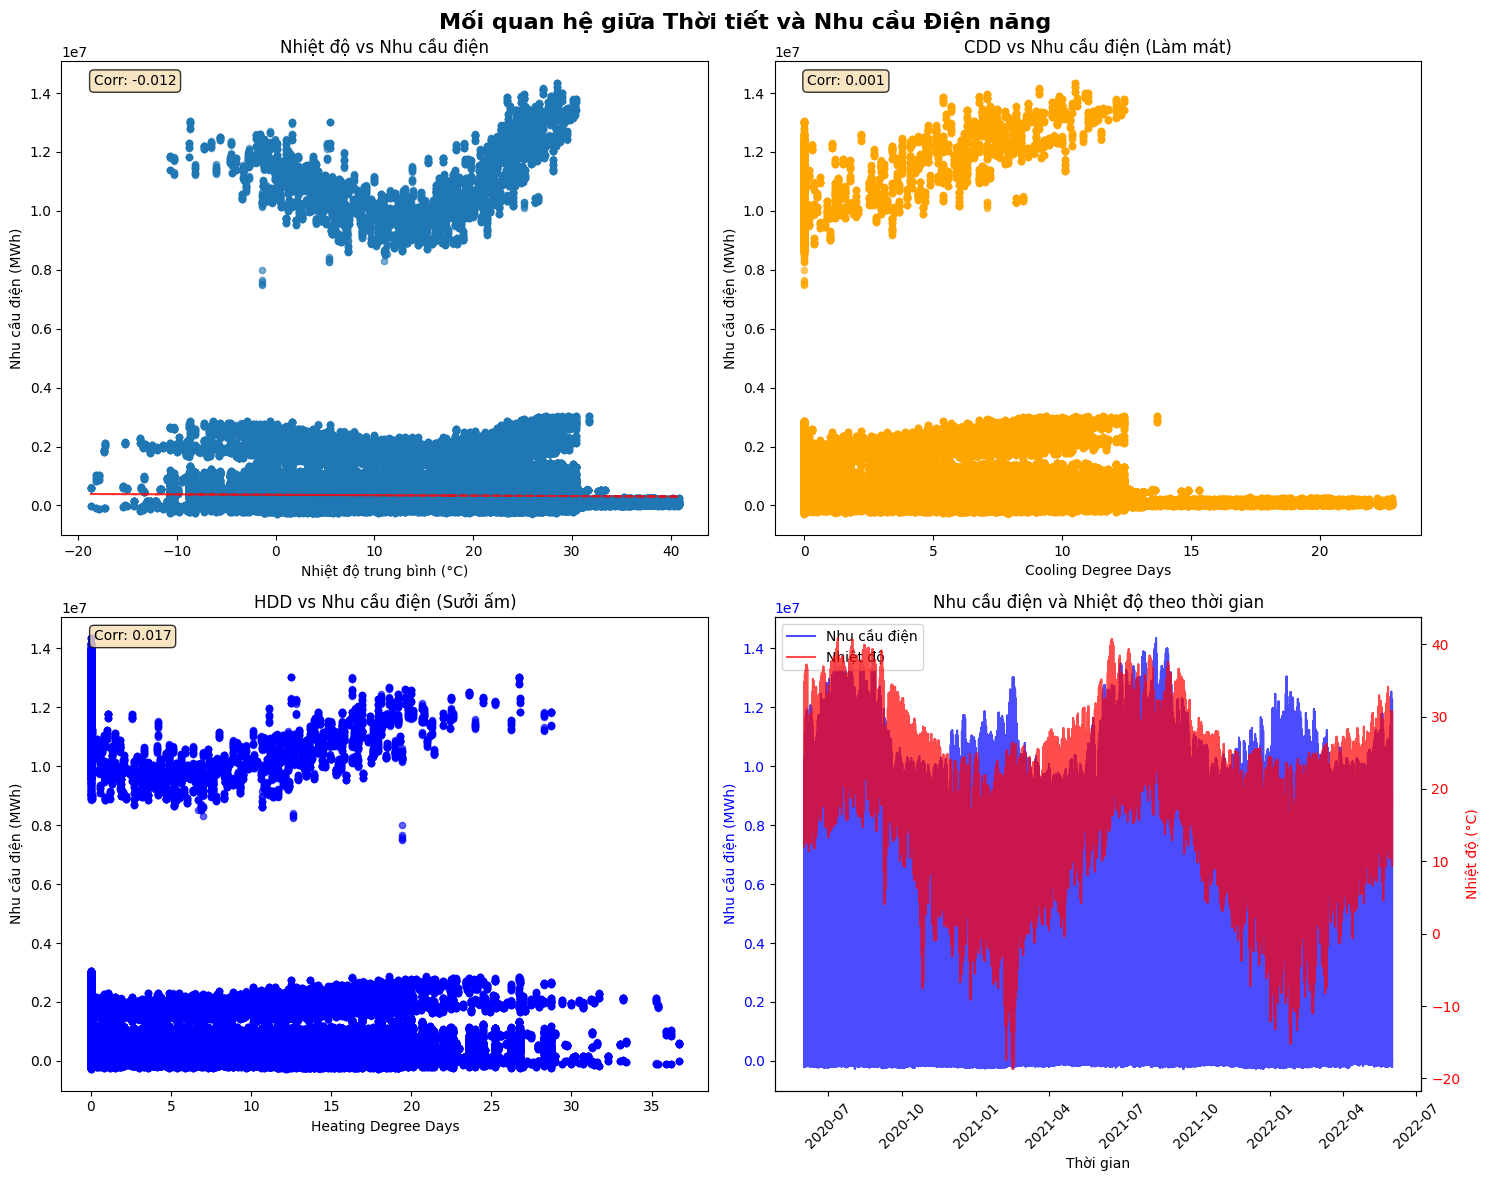

\n🔗 MA TRẬN TƯƠNG QUAN:
       value   tavg   tmax   tmin    cdd    hdd   prcp   wspd
value  1.000 -0.012 -0.015 -0.007  0.001  0.017  0.005  0.025
tavg  -0.012  1.000  0.980  0.978  0.815 -0.943  0.071 -0.195
tmax  -0.015  0.980  1.000  0.929  0.793 -0.928  0.032 -0.221
tmin  -0.007  0.978  0.929  1.000  0.804 -0.919  0.101 -0.187
cdd    0.001  0.815  0.793  0.804  1.000 -0.576  0.057 -0.137
hdd    0.017 -0.943 -0.928 -0.919 -0.576  1.000 -0.068  0.196
prcp   0.005  0.071  0.032  0.101  0.057 -0.068  1.000  0.139
wspd   0.025 -0.195 -0.221 -0.187 -0.137  0.196  0.139  1.000


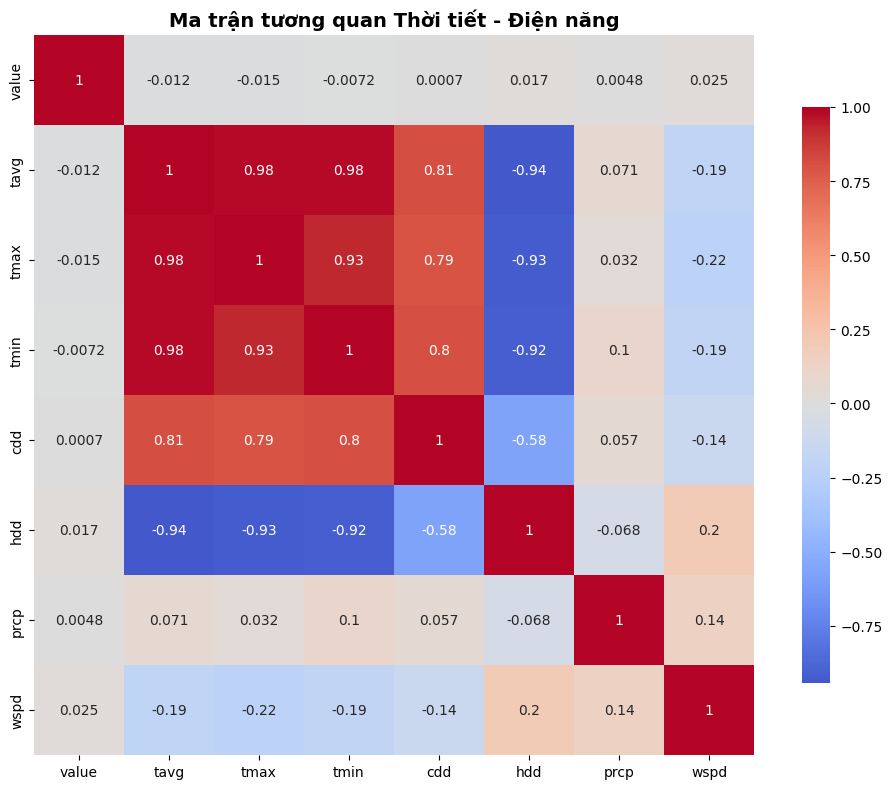

\n🗓️ PHÂN TÍCH THEO MÙA:
            value                                 tavg   cdd    hdd
             mean         std     min       max   mean  mean   mean
season                                                             
Fall    318994.67  1105145.02 -274790  12709415  17.07  2.15   3.08
Spring  309670.48  1073916.16 -240084  12533201  13.66   1.1   5.43
Summer  383542.79  1335129.26 -264468  14344747  25.26   7.3   0.04
Winter  342941.70  1193613.67 -277749  13048728   4.53  0.16  13.62


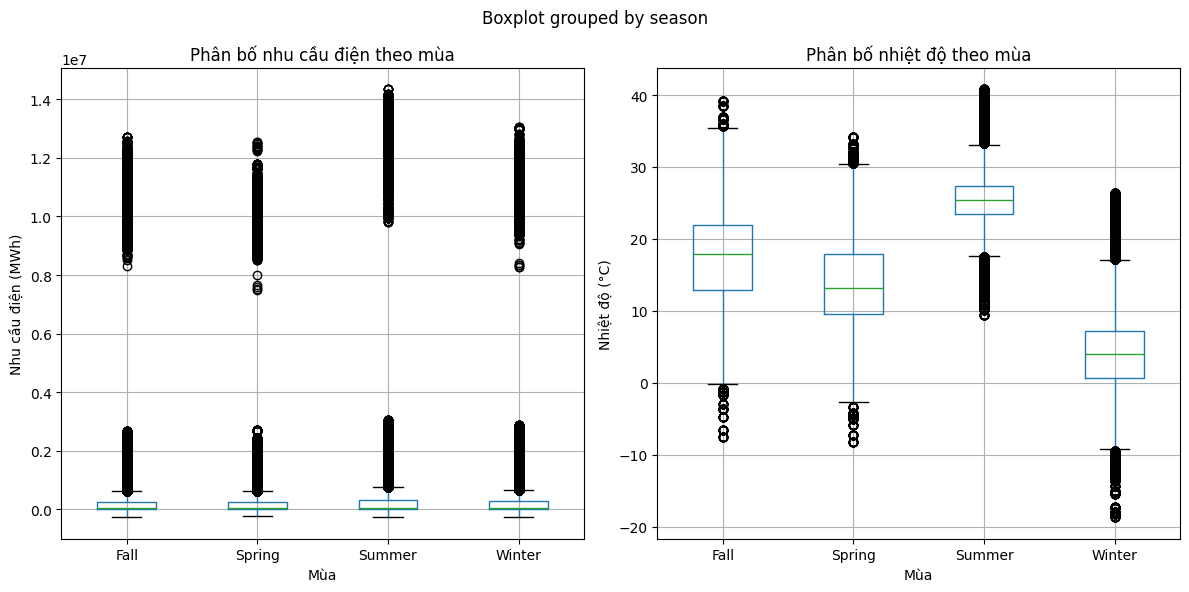

\n✅ Hoàn thành phân tích mối quan hệ thời tiết - điện năng!


In [ ]:
# Phân tích và trực quan hóa mối quan hệ thời tiết - điện năng

def analyze_weather_energy_relationship(df: pd.DataFrame):
    """
    Phân tích mối quan hệ giữa thời tiết và nhu cầu điện năng
    """
    if df.empty or 'value' not in df.columns:
        print("❌ Không có dữ liệu để phân tích")
        return

    print("📊 PHÂN TÍCH MỐI QUAN HỆ THỜI TIẾT - ĐIỆN NĂNG")
    print("=" * 60)

    # Tạo figure với subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Mối quan hệ giữa Thời tiết và Nhu cầu Điện năng', fontsize=16, fontweight='bold')

    # 1. Scatter plot: Nhiệt độ vs Nhu cầu điện
    if 'tavg' in df.columns:
        axes[0, 0].scatter(df['tavg'], df['value'], alpha=0.6, s=20)
        axes[0, 0].set_xlabel('Nhiệt độ trung bình (°C)')
        axes[0, 0].set_ylabel('Nhu cầu điện (MWh)')
        axes[0, 0].set_title('Nhiệt độ vs Nhu cầu điện')

        # Thêm trend line
        z = np.polyfit(df['tavg'].dropna(), df.loc[df['tavg'].notna(), 'value'], 1)
        p = np.poly1d(z)
        axes[0, 0].plot(df['tavg'].dropna(), p(df['tavg'].dropna()), "r--", alpha=0.8)

        # Tính correlation
        corr = df[['tavg', 'value']].corr().iloc[0, 1]
        axes[0, 0].text(0.05, 0.95, f'Corr: {corr:.3f}', transform=axes[0, 0].transAxes,
                       bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

    # 2. CDD vs Nhu cầu điện (cooling demand)
    if 'cdd' in df.columns:
        axes[0, 1].scatter(df['cdd'], df['value'], alpha=0.6, s=20, color='orange')
        axes[0, 1].set_xlabel('Cooling Degree Days')
        axes[0, 1].set_ylabel('Nhu cầu điện (MWh)')
        axes[0, 1].set_title('CDD vs Nhu cầu điện (Làm mát)')

        # Correlation
        corr_cdd = df[['cdd', 'value']].corr().iloc[0, 1]
        axes[0, 1].text(0.05, 0.95, f'Corr: {corr_cdd:.3f}', transform=axes[0, 1].transAxes,
                       bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

    # 3. HDD vs Nhu cầu điện (heating demand)
    if 'hdd' in df.columns:
        axes[1, 0].scatter(df['hdd'], df['value'], alpha=0.6, s=20, color='blue')
        axes[1, 0].set_xlabel('Heating Degree Days')
        axes[1, 0].set_ylabel('Nhu cầu điện (MWh)')
        axes[1, 0].set_title('HDD vs Nhu cầu điện (Sưởi ấm)')

        # Correlation
        corr_hdd = df[['hdd', 'value']].corr().iloc[0, 1]
        axes[1, 0].text(0.05, 0.95, f'Corr: {corr_hdd:.3f}', transform=axes[1, 0].transAxes,
                       bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

    # 4. Time series: Nhu cầu điện và nhiệt độ theo thời gian
    if 'period' in df.columns and 'tavg' in df.columns:
        # Sort by date
        df_sorted = df.sort_values('period')

        # Dual y-axis
        ax4 = axes[1, 1]
        ax4_twin = ax4.twinx()

        # Plot demand
        line1 = ax4.plot(df_sorted['period'], df_sorted['value'], 'b-', alpha=0.7, label='Nhu cầu điện')
        ax4.set_xlabel('Thời gian')
        ax4.set_ylabel('Nhu cầu điện (MWh)', color='b')
        ax4.tick_params(axis='y', labelcolor='b')

        # Plot temperature
        line2 = ax4_twin.plot(df_sorted['period'], df_sorted['tavg'], 'r-', alpha=0.7, label='Nhiệt độ')
        ax4_twin.set_ylabel('Nhiệt độ (°C)', color='r')
        ax4_twin.tick_params(axis='y', labelcolor='r')

        # Rotate x-axis labels
        ax4.tick_params(axis='x', rotation=45)

        ax4.set_title('Nhu cầu điện và Nhiệt độ theo thời gian')

        # Legend
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax4.legend(lines, labels, loc='upper left')

    plt.tight_layout()
    plt.show()

    # In thống kê correlation
    print("\\n🔗 MA TRẬN TƯƠNG QUAN:")
    weather_energy_cols = ['value']
    if 'tavg' in df.columns:
        weather_energy_cols.append('tavg')
    if 'tmax' in df.columns:
        weather_energy_cols.append('tmax')
    if 'tmin' in df.columns:
        weather_energy_cols.append('tmin')
    if 'cdd' in df.columns:
        weather_energy_cols.append('cdd')
    if 'hdd' in df.columns:
        weather_energy_cols.append('hdd')
    if 'prcp' in df.columns:
        weather_energy_cols.append('prcp')
    if 'wspd' in df.columns:
        weather_energy_cols.append('wspd')

    if len(weather_energy_cols) > 1:
        correlation_matrix = df[weather_energy_cols].corr()
        print(correlation_matrix.round(3))

        # Heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, cbar_kws={"shrink": .8})
        plt.title('Ma trận tương quan Thời tiết - Điện năng', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    # Phân tích theo mùa
    if 'season' in df.columns:
        print("\\n🗓️ PHÂN TÍCH THEO MÙA:")
        seasonal_stats = df.groupby('season').agg({
            'value': ['mean', 'std', 'min', 'max'],
            'tavg': 'mean' if 'tavg' in df.columns else lambda x: None,
            'cdd': 'mean' if 'cdd' in df.columns else lambda x: None,
            'hdd': 'mean' if 'hdd' in df.columns else lambda x: None
        }).round(2)
        print(seasonal_stats)

        # Box plot theo mùa
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        df.boxplot(column='value', by='season', ax=plt.gca())
        plt.title('Phân bố nhu cầu điện theo mùa')
        plt.xlabel('Mùa')
        plt.ylabel('Nhu cầu điện (MWh)')

        if 'tavg' in df.columns:
            plt.subplot(1, 2, 2)
            df.boxplot(column='tavg', by='season', ax=plt.gca())
            plt.title('Phân bố nhiệt độ theo mùa')
            plt.xlabel('Mùa')
            plt.ylabel('Nhiệt độ (°C)')

        plt.tight_layout()
        plt.show()

    print("\\n✅ Hoàn thành phân tích mối quan hệ thời tiết - điện năng!")

# Sử dụng hàm phân tích (nếu có dữ liệu)
if 'integrated_data' in locals() and not integrated_data.empty:
    analyze_weather_energy_relationship(integrated_data)
else:
    print("⚠️ Chưa có dữ liệu tích hợp để phân tích.")
    print("💡 Hãy chạy cell thu thập dữ liệu ở trên trước.")

### Display

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

df_region = pd.read_csv("/content/drive/MyDrive/DS200/energy_weather_data_2020-06-01_to_2022-06-01_US_Center.csv")
df_region.head(10)

,period,respondent,respondent-name,type,type-name,timezone,timezone-description,value,value-units,year,month,day,day_of_week,day_of_year,week_of_year,is_weekend,quarter,month_day,season,date,is_holiday,is_business_day,demand_lag_1d,demand_lag_7d,demand_lag_30d,demand_lag_365d,demand_ma_7d,demand_ma_30d,demand_ma_90d,demand_trend_7d,demand_trend_30d,demand_growth_rate_7d,demand_growth_rate_30d,demand_yoy_change,demand_yoy_growth,demand_std_30d,demand_max_30d,demand_min_30d,demand_volatility_30d,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos,time,region,tavg,tmin,tmax,prcp,wspd,pres,tsun,temp_range,cdd,hdd,temp_extreme_cold,temp_extreme_hot,wind_high,rain_day,heavy_rain,pressure_low,pressure_high,tavg_lag1,tavg_lag3,tavg_ma7,tmax_lag1,tmax_lag3,tmax_ma7,tmin_lag1,tmin_lag3,tmin_ma7,prcp_lag1,prcp_lag3,prcp_ma7,wspd_lag1,wspd_lag3,wspd_ma7,discomfort_index,heat_stress,cooling_demand_factor,heating_demand_factor,weather_severity_index
0,2020-06-01,AEC,PowerSouth Energy Cooperative,D,Demand,Arizona,Arizona,14161,megawatthours,2020,6,1,0,153,23,0,2,06-01,Summer,2020-06-01,0,1,NaN,NaN,NaN,NaN,14161.000000,14161.000000,14161.000000,NaN,NaN,0.000000,0.0,NaN,0.0,NaN,14161.0,14161.0,NaN,0.000000,1.00000,1.224647e-16,-1.0,0.487847,-0.872929,2020-06-01,AEC,17.4,11.7,23.3,0.0,8.5,1021.8,NaN,11.6,0.0,0.6,0,0,0,0,0,0,1,NaN,NaN,17.40,NaN,NaN,23.3,NaN,NaN,11.70,NaN,NaN,0.0,NaN,NaN,8.50,60.088,0.0,0.000000,0.016349,0
1,2020-06-01,AEC,PowerSouth Energy Cooperative,D,Demand,Central,Central,14023,megawatthours,2020,6,1,0,153,23,0,2,06-01,Summer,2020-06-01,0,1,14161.0,NaN,NaN,NaN,14092.000000,14092.000000,14092.000000,NaN,NaN,0.000000,0.0,NaN,0.0,97.580736,14161.0,14023.0,0.006925,0.000000,1.00000,1.224647e-16,-1.0,0.487847,-0.872929,2020-06-01,AEC,17.4,11.7,23.3,0.0,8.5,1021.8,NaN,11.6,0.0,0.6,0,0,0,0,0,0,1,NaN,NaN,17.40,NaN,NaN,23.3,NaN,NaN,11.70,NaN,NaN,0.0,NaN,NaN,8.50,60.088,0.0,0.000000,0.016349,0
2,2020-06-01,AEC,PowerSouth Energy Cooperative,D,Demand,Eastern,Eastern,13960,megawatthours,2020,6,1,0,153,23,0,2,06-01,Summer,2020-06-01,0,1,14023.0,NaN,NaN,NaN,14048.000000,14048.000000,14048.000000,NaN,NaN,0.000000,0.0,NaN,0.0,102.805642,14161.0,13960.0,0.007318,0.000000,1.00000,1.224647e-16,-1.0,0.487847,-0.872929,2020-06-01,AEC,17.4,11.7,23.3,0.0,8.5,1021.8,NaN,11.6,0.0,0.6,0,0,0,0,0,0,1,NaN,NaN,17.40,NaN,NaN,23.3,NaN,NaN,11.70,NaN,NaN,0.0,NaN,NaN,8.50,60.088,0.0,0.000000,0.016349,0
3,2020-06-01,AEC,PowerSouth Energy Cooperative,D,Demand,Mountain,Mountain,14103,megawatthours,2020,6,1,0,153,23,0,2,06-01,Summer,2020-06-01,0,1,13960.0,NaN,NaN,NaN,14061.750000,14061.750000,14061.750000,NaN,NaN,0.000000,0.0,NaN,0.0,88.330346,14161.0,13960.0,0.006282,0.000000,1.00000,1.224647e-16,-1.0,0.487847,-0.872929,2020-06-01,AEC,17.4,11.7,23.3,0.0,8.5,1021.8,NaN,11.6,0.0,0.6,0,0,0,0,0,0,1,NaN,NaN,17.40,NaN,NaN,23.3,NaN,NaN,11.70,NaN,NaN,0.0,NaN,NaN,8.50,60.088,0.0,0.000000,0.016349,0
4,2020-06-01,AEC,PowerSouth Energy Cooperative,D,Demand,Pacific,Pacific,14161,megawatthours,2020,6,1,0,153,23,0,2,06-01,Summer,2020-06-01,0,1,14103.0,NaN,NaN,NaN,14081.600000,14081.600000,14081.600000,NaN,NaN,0.000000,0.0,NaN,0.0,88.440941,14161.0,13960.0,0.006281,0.000000,1.00000,1.224647e-16,-1.0,0.487847,-0.872929,2020-06-01,AEC,17.4,11.7,23.3,0.0,8.5,1021.8,NaN,11.6,0.0,0.6,0,0,0,0,0,0,1,NaN,NaN,17.40,NaN,NaN,23.3,NaN,NaN,11.70,NaN,NaN,0.0,NaN,NaN,8.50,60.088,0.0,0.000000,0.016349,0
5,2020-06-02,AEC,PowerSouth Energy Cooperative,D,Demand,Arizona,Arizona,13074,megawatthours,2020,6,2,1,154,23,0,2,06-02,Summer,2020-06-02,0,1,14161.0,NaN,NaN,NaN,13913.666667,13913.666667,13913.666667,NaN,NaN,0.000000,0.0,NaN,0.0,418.887893,14161.0,13074.0,0.030106,0.781831,0.62349,1.224647e-16,-1.0,0.472759,-0.881192,2020-06-02,AEC,19.3,15.0,23.3,3.6,9.8,1015.4,NaN,8.3,1.3,0.0,0,0,0,1,0,0,0,17.4,NaN,18.35,23.3,NaN,23.3,11.7,NaN,13.35,0.0,NaN,1.8,8.5,NaN,9.15,62.216,0.0,0.057018,0.000000,0
6,2020-06-02,AEC,PowerSouth Energy Cooperative,D,Demand,Central,Central,131

In [ ]:
df_region.isnull().sum().head(10)

,0
period,0
respondent,0
respondent-name,0
type,0
type-name,0
timezone,0
timezone-description,0
value,0
value-units,0
year,0


In [ ]:
df_region['year'].unique()

array([2020, 2021, 2022])

In [ ]:
df_region.shape

(1058006, 84)

In [ ]:
df_region['type-name'].unique()

array(['Demand', 'Day-ahead demand forecast', 'Net generation',
       'Total interchange'], dtype=object)

In [ ]:
df_region['timezone'].unique()

array(['Arizona', 'Central', 'Eastern', 'Mountain', 'Pacific'],
      dtype=object)

In [ ]:
df_region['type-name'].value_counts()

,count
type-name,
Net generation,283330
Total interchange,281542
Demand,246938
Day-ahead demand forecast,246196


- Net Generation (Sản lượng điện ròng): Là tổng lượng điện được phát ra từ các nhà máy điện, trừ đi lượng điện mà chính nhà máy sử dụng cho vận hành nội bộ.           Net Generation=Total Generation−Electricity Used by Plant
- Total Interchange (Tổng điện trao đổi): Lượng điện trao đổi giữa các khu vực lưới điện khác nhau, bao gồm cả nhập (import) và xuất (export) điện.             
Giá trị dương → nhập điện từ ngoài vào vùng.      
Giá trị âm → xuất điện ra vùng khác.
- Demand (Nhu cầu tiêu thụ điện): Lượng điện thực tế được người dùng tiêu thụ tại một thời điểm trong hệ thống điện.       
- Day-ahead Demand Forecast (Dự báo nhu cầu điện trước 1 ngày): Là lượng điện được dự báo trước một ngày, nhằm mục đích lên kế hoạch vận hành lưới điện và phân bổ nguồn phát hợp lý.     


*** Mối quan hệ giữa các thành phần:        
- Net Generation+Total Interchange≈Demand           
- Nghĩa là tổng điện phát ra cộng với điện trao đổi ròng sẽ xấp xỉ bằng tổng nhu cầu tiêu thụ trong khu vực.
